In [325]:
import os
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from talib import  BBANDS, ROC, EMA, MACD
from hmmlearn.hmm import GaussianHMM
from pykalman import KalmanFilter
#from datetime import datetime

data_dir = 'data'

# List all JSON files in the directory
json_files = [f for f in os.listdir(data_dir) if f.endswith('.json')]

# Initialize an empty list to store DataFrames
df_list = []

# Read each JSON file and append the DataFrame to the list
for json_file in json_files:
    file_path = os.path.join(data_dir, json_file)
    df = pd.read_json(file_path)
    df_list.append(df)

# Concatenate all DataFrames into a single DataFrame
df_org = pd.concat(df_list, ignore_index=True)


def compute_average_ask_bid(price_data):
    if( price_data['Ask'] is not None and price_data['Bid'] is not None):
        return (price_data['Ask'] + price_data['Bid']) / 2
    else:
        return None

df_org['openPrices'] = [compute_average_ask_bid(OpenPrice) for OpenPrice in df_org["OpenPrice"]];
df_org['highPrices'] = [compute_average_ask_bid(HighPrice) for HighPrice in df_org["HighPrice"]];
df_org['lowPrices'] = [compute_average_ask_bid(LowPrice) for LowPrice in df_org["LowPrice"]];
df_org['closedprices'] = [compute_average_ask_bid(closedprice) for closedprice in df_org["ClosePrice"]];

## Drop rows with None values
df_org.dropna(subset=['closedprices', 'highPrices', 'lowPrices', 'openPrices'], inplace=True)


# Compute olhc4
df_org['olhc4'] = (df_org['closedprices'] + df_org['highPrices'] + df_org['lowPrices'] + df_org['openPrices']) / 4
# Compute log returns
df_org['log_returns'] = np.log(df_org['olhc4'] / df_org['olhc4'].shift(1))
df_org['momentum'] = np.log(df_org['olhc4']/df_org['olhc4'].shift(20))

df_org['SnapshotTime'] = pd.to_datetime(df_org['SnapshotTime'], format='ISO8601')

# Extract unique days
df_org['Date'] = df_org['SnapshotTime'].dt.date
unique_days = df_org['Date'].unique()

df_org.head()

,ClosePrice,HighPrice,LastTradedVolume,LowPrice,OpenPrice,SnapshotTime,SnapshotTimeUTC,openPrices,highPrices,lowPrices,closedprices,olhc4,log_returns,momentum,Date
0,"{'Ask': 7290.0, 'Bid': 7288.0, 'LastTraded': N...","{'Ask': 7297.0, 'Bid': 7294.0, 'LastTraded': N...",74,"{'Ask': 7288.7, 'Bid': 7286.7, 'LastTraded': N...","{'Ask': 7296.2, 'Bid': 7293.2, 'LastTraded': N...",2024-11-18 08:00:00,2024-11-18T07:00:00,7294.7,7295.5,7287.7,7289.0,7291.725,NaN,NaN,2024-11-18
1,"{'Ask': 7282.7, 'Bid': 7280.7, 'LastTraded': N...","{'Ask': 7289.0, 'Bid': 7287.0, 'LastTraded': N...",53,"{'Ask': 7282.7, 'Bid': 7280.7, 'LastTraded': N...","{'Ask': 7289.0, 'Bid': 7287.0, 'LastTraded': N...",2024-11-18 08:01:00,2024-11-18T07:01:00,7288.0,7288.0,7281.7,7281.7,7284.850,-0.000943,NaN,2024-11-18
2,"{'Ask': 7278.0, 'Bid': 7276.0, 'LastTraded': N...","{'Ask': 7283.2, 'Bid': 7281.2, 'LastTraded': N...",18,"{'Ask': 7277.7, 'Bid': 7275.7, 'LastTraded': N...","{'Ask': 7283.2, 'Bid': 7281.2, 'LastTraded': N...",2024-11-18 08:02:00,2024-11-18T07:02:00,7282.2,7282.2,7276.7,7277.0,7279.525,-0.000731,NaN,2024-11-18
3,"{'Ask': 7283.2, 'Bid': 7281.2, 'LastTraded': N...","{'Ask': 7283.2, 'Bid': 7281.2, 'LastTraded': N...",25,"{'Ask': 7278.2, 'Bid': 7276.2, 'LastTraded': N...","{'Ask': 7278.2, 'Bid': 7276.2, 'LastTraded': N...",2024-11-18 08:03:00,2024-11-18T07:03:00,7277.2,7282.2,7277.2,7282.2,7279.700,0.000024,NaN,2024-11-18
4,"{'Ask': 7279.7, 'Bid': 7277.7, 'LastTraded': N...","{'Ask': 7283.0, 'Bid': 7281.0, 'LastTraded': N...",22,"{'Ask': 7279.2, 'Bid': 7277.2, 'LastTraded': N...","{'Ask': 7283.0, 'Bid': 7281.0, 'LastTraded': N...",2024-11-18 08:04:00,2024-11-18T07:04:00,7282.0,7282.0,7278.2,7278.7,7280.225,0.000072,NaN,2024-11-18


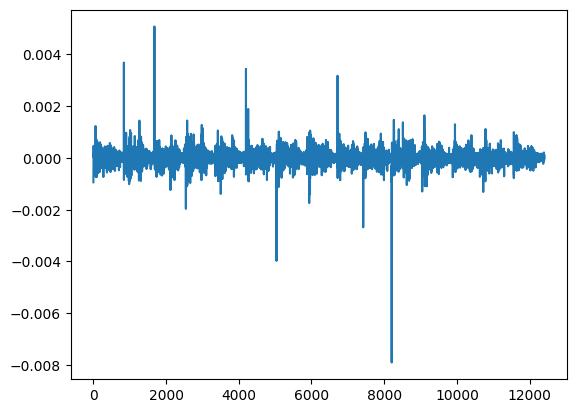

In [326]:


plt.plot(df_org['log_returns'] )
plt.show()

In [327]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12391 entries, 0 to 12405
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ClosePrice        12391 non-null  object        
 1   HighPrice         12391 non-null  object        
 2   LastTradedVolume  12391 non-null  int64         
 3   LowPrice          12391 non-null  object        
 4   OpenPrice         12391 non-null  object        
 5   SnapshotTime      12391 non-null  datetime64[ns]
 6   SnapshotTimeUTC   12391 non-null  object        
 7   openPrices        12391 non-null  float64       
 8   highPrices        12391 non-null  float64       
 9   lowPrices         12391 non-null  float64       
 10  closedprices      12391 non-null  float64       
 11  olhc4             12391 non-null  float64       
 12  log_returns       12390 non-null  float64       
 13  momentum          12371 non-null  float64       
 14  Date              12391 non

In [328]:

up, mid, low = BBANDS(df_org.olhc4, timeperiod=21, nbdevup=1.5, nbdevdn=1.5, matype=0)
roc10= ROC(df_org.olhc4, timeperiod=10 )
roc13= ROC(df_org.olhc4, timeperiod=13 )
roc15= ROC(df_org.olhc4, timeperiod=15 )
roc20= ROC(df_org.olhc4, timeperiod=20 )
#kstmt = 1.618 * EMA(roc10, 10) +  1.5*EMA(roc13,13) +  1.382 * EMA(roc15,15) + 1.236*EMA(roc20,20)


kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)


kf2 = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.1)

kstmt = 1.618 * roc10 +  1.5*roc13 +  1.382 * roc15+ 1.236*roc20

olhc4_filter, _ = kf.filter(df_org['closedprices'])
olhc4_filter2, _ = kf2.filter(df_org['closedprices'])
#




roc300= ROC(df_org.olhc4, timeperiod=50 )
roc400= ROC(df_org.olhc4, timeperiod=100 )
roc600= ROC(df_org.olhc4, timeperiod=150 )
roc800= ROC(df_org.olhc4, timeperiod=200 )
kstlt = 1.618 * EMA(roc300, 30) +  1.5*EMA(roc400,40) +  1.382 * EMA(roc600,60) + 1.236*EMA(roc800,80)

kstmtup, kstmtmid, kstmtlow = BBANDS(kstmt, timeperiod=40, nbdevup=1.2, nbdevdn=1.2, matype=0)

df_org['roc10'] = roc10
df_org['kstmt'] = kstmt 
df_org['kstmtup'] = kstmtup
df_org['kstmtmid'] = kstmtmid
df_org['kstmtlow'] =  kstmtlow
df_org['kstlt'] = kstlt 
df_org['up'] = up
df_org['low'] = low
df_org['olhc4_filter'] = olhc4_filter
df_org['olhc4_filter2'] = olhc4_filter2




In [329]:
#data = pd.DataFrame({'olhc4': df_org['olhc4'], 'upper': up, 'middle': mid, 'lower': low})

In [330]:

#data.plot(figsize=(20, 10), title='Bollinger Bands')

np.random.seed(51) # 3 avec seed 51 ['log_returns',"kstlt", "kstmt"   ] 
df_org.dropna( inplace=True) # = df_org[["SnapshotTime", "Date", "log_returns", "kstlt", "kstmt", 'kstmtup' "olhc4", "momentum"]].dropna()

features = ['log_returns',"kstlt", "kstmt"   ]  # '',  , "kstlt", "kstmt" 

print(df_org.shape[0])
hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, tol=1, algorithm='map')
hmm_model.fit(np.array(df_org[features]))
print("Model Score: ", hmm_model.score(np.array(df_org[features])))


12112
Model Score:  41751.032127670696


In [331]:
df_org['state']=hmm_model.predict(np.array(df_org[features]))

In [332]:
#if df_org['state'] == 2 and df_org['state'].shift(1) !=  2:
df_org['position'] = 0
# Set 'position' to 1 where 'state' is 2
df_org.loc[ (df_org['state'] == 1) &  (df_org['olhc4_filter'] < df_org['olhc4_filter2']), 'position'] = 1
df_org.loc[ (df_org['state'] == 2) &  (df_org['olhc4_filter'] > df_org['olhc4_filter2']), 'position'] = 2

In [333]:

fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# Add traces for the initial plot (first day)
initial_day = unique_days[3]
print(initial_day)

df_day = df_org[df_org['Date'] == initial_day]

df_buy = df_day.loc[df_day['position'] == 1, ['SnapshotTime','closedprices']]
df_sell = df_day.loc[df_day['position'] == 2, ['SnapshotTime','closedprices']]

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['kstmt'],
                         name = 'kstmt',
                         opacity = 0.5), row=1, col=1)

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['kstmtup'],
                        line_color = 'gray',
                         line = {'dash': 'dash'},
                         name = 'kst upper band',
                         opacity = 0.5), row=1, col=1)

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['kstmtlow'],
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         fill = 'tonexty',
                         name = 'lower band',
                         opacity = 0.3), row=1, col=1)


fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['kstlt'],
                         name = 'kstlt',
                         opacity = 0.5), row=2, col=1)

fig.append_trace(  go.Candlestick(
                x=df_day['SnapshotTime'],
                open=df_day['openPrices'],
                high=df_day['highPrices'],
                low=df_day['lowPrices'],
                close=df_day['closedprices']), row=3, col=1)

#fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
#                         y = df_day['olhc4'],
#                        line_color = 'red',
#                         name = 'filter',
#                         opacity = 1), row=3, col=1)


fig.append_trace(go.Scatter(x=df_buy['SnapshotTime'], y=df_buy['closedprices'] + 20, mode='markers',
    marker=dict(symbol='x', size=7, line=dict(width=1), color='green'), name = 'Buy'), row=3, col=1)

fig.append_trace(go.Scatter(x=df_sell['SnapshotTime'], y=df_sell['closedprices'] - 20, mode='markers',
    marker=dict(symbol='x', size=7, line=dict(width=1), color='red'), name = 'Sell'), row=3, col=1)

mark = dict(color=[ 'yellow' if x == 0 else 'red' if x == 2 else 'green'  for x in df_day['state']])

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['olhc4_filter'],
                        line_color = 'yellow',
                         name = 'filter',
                         opacity = 1, mode='markers', marker = mark), row=3, col=1)

fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['olhc4_filter2'],
                        line_color = 'red',
                         name = 'filter',
                         opacity = 1), row=3, col=1)


fig.append_trace(   go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['up'],
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         name = 'upper band',
                         opacity = 0.5), row=3, col=1)

fig.append_trace(  go.Scatter(x = df_day['SnapshotTime'],
                         y = df_day['low'],
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         fill = 'tonexty',
                         name = 'lower band',
                         opacity = 0.3), row=3, col=1)

dropdown_buttons = [
    {
        'label': str(day),
        'method': 'update',
       'args': [
            {
                'x': [df_org[df_org['Date'] == day]['SnapshotTime']] * 11,
                'y': [
                    df_org[df_org['Date'] == day]['openPrices'],
                    df_org[df_org['Date'] == day]['highPrices'],
                    df_org[df_org['Date'] == day]['lowPrices'],
                    df_org[df_org['Date'] == day]['closedprices'],
                    df_org[df_org['Date'] == day]['olhc4'],
                    df_org[df_org['Date'] == day]['log_returns'],
                    df_org[df_org['Date'] == day]['kstmt'], 
                    df_org[df_org['Date'] == day]['kstmtup'], 
                    df_org[df_org['Date'] == day]['kstmtlow'],
                    df_org[df_org['Date'] == day]['up'],
                    df_org[df_org['Date'] == day]['low']
                ]
            },
            {
                'xaxis': {
                    'range': [
                        df_org[df_org['Date'] == day]['SnapshotTime'].min(),
                        df_org[df_org['Date'] == day]['SnapshotTime'].max()
                    ]
                },
                'yaxis2': {
                    'range': [
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].min().min(),
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].max().max()
                    ]
                },
                'yaxis': {
#                    'range': [
#                        df_org[df_org['Date'] == day]['kstmt'].min(),
#                        df_org[df_org['Date'] == day]['kstmt'].max()
#                    ]
                    'range': [
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].min().min(),
                        df_org[df_org['Date'] == day][['openPrices', 'highPrices', 'lowPrices', 'closedprices']].max().max()
                    ]
                }
            }
        ]
    }
    for day in unique_days
]



# Update layout to include dropdown menu and range slider for the second row
fig.update_layout(
    width=1790,
    height=3000,
    template='plotly_dark',
    xaxis2=dict(
        rangeslider=dict(
            visible=False
        )
    ),
     xaxis3=dict(
        rangeslider=dict(
            visible=True
        )
    )
    #,
    #updatemenus=[
    #   {
    #        'buttons': dropdown_buttons,
    #        'direction': 'down',
    #        'showactive': True,
    #    }
    #]
)

fig.update_yaxes(title_text="Price", row=2, col=1)
fig.update_yaxes(title_text="ROC", row=1, col=1)

fig.show()

2024-11-21


In [334]:
#np.random.seed(51) # 3 avec seed 51 ['log_returns',"kstlt", "kstmt"   ] 
#data = df_org[["SnapshotTime", "Date", "log_returns", "kstlt", "kstmt", "olhc4", "momentum"]].dropna()

#features = ['log_returns',"kstlt", "kstmt"   ]  # '',  , 

#print(data.shape[0])
#hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, tol=1, algorithm='map')
#hmm_model.fit(np.array(data[features]))
#print("Model Score: ", hmm_model.score(np.array(data[features])))

#data.head()


In [335]:

#data['state']=hmm_model.predict(np.array(data[features]))
#data.head()


analyse distribution des etats cahche

3.0008477799271276e-07
1.5562933612067678e-05
-1.6393541407140027e-05


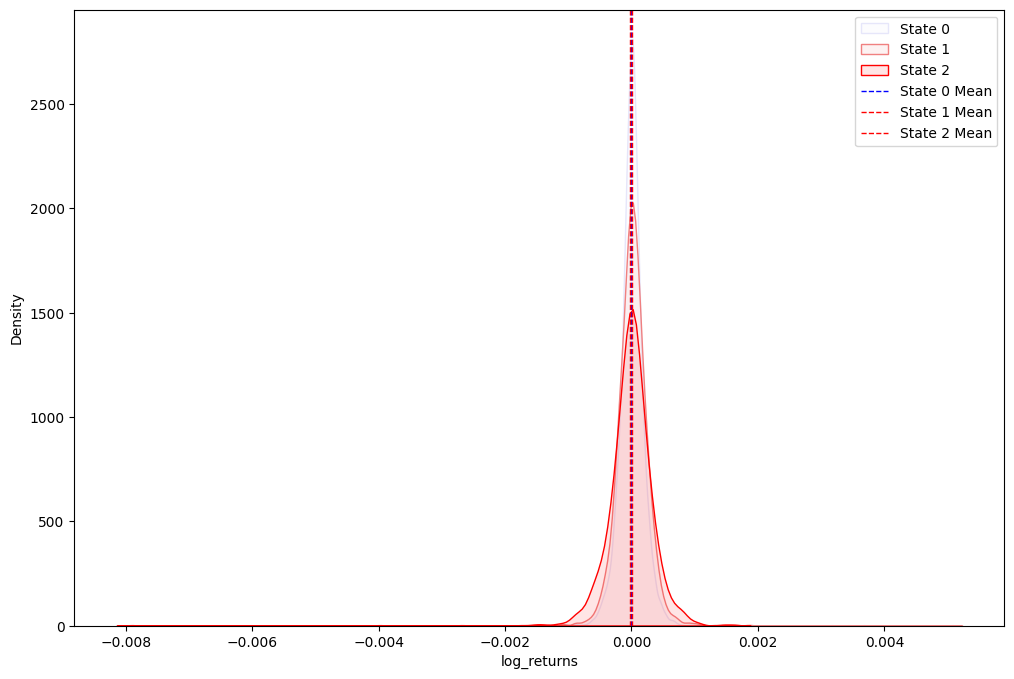

In [336]:
state0 = df_org[df_org['state'] == 0 ]
state1 = df_org[df_org['state'] == 1 ]
state2 = df_org[df_org['state'] == 2 ]

plt.figure(figsize=(12, 8))
sns.kdeplot(state0['log_returns'], color='lavender', label='State 0', fill=True, alpha=0.1)
sns.kdeplot(state1['log_returns'], color='lightcoral', label='State 1', fill=True, alpha=0.1)
sns.kdeplot(state2['log_returns'], color='red', label='State 2', fill=True, alpha=0.1)
plt.axvline( state0['log_returns'].mean(), color='blue', linestyle='dashed', linewidth=1, label='State 0 Mean')
plt.axvline( state1['log_returns'].mean(), color='red', linestyle='dashed', linewidth=1,  label='State 1 Mean')
plt.axvline( state2['log_returns'].mean(), color='red', linestyle='dashed', linewidth=1,  label='State 2 Mean')
plt.legend()
#state0.head()
#state1.head()

print(state0['log_returns'].mean())
print(state1['log_returns'].mean())
print(state2['log_returns'].mean())

In [337]:
#MACD_FAST = 12
#MACD_SLOW = 26
#MACD_SIGNAL = 9

#macd,macdSignal, macdHist  = MACD(graph.olhc4, fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)

#graph.loc[:, 'macd'] = macd
#graph.loc[:, 'macdSignal'] = macdSignal
#graph.loc[:, 'macdHist'] = macdHist

#graph.head()

#fig = go.Figure(data=[go.Scatter(x=graph['SnapshotTime'], y=graph['macdHist'],  mode='lines+markers', marker = mark)])

#layout = go.Layout(template='plotly_dark',
#                   title ='macd' , height=500,
#                    xaxis_rangeslider_visible=True)
#fig.update_layout(layout)
#fig.show()